In [50]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage
from IPython.display import SVG
import ipywidgets as widgets
from ipywidgets import interact
import json
from cgr.filepaths import filepaths
from cgr.draw import draw_molecule, draw_reaction
from cgr.cheminfo import rc_neighborhood
from itertools import chain
from collections import defaultdict
import matplotlib.pyplot as plt

In [51]:
def show_highlighted_grid(smiles: str, rcs: list[list], legends: list[str], n_cols: int, sub_img_size: tuple = (200, 200)):
    mgrid = MolsToGridImage(
        mols=[Chem.MolFromSmiles(smi) for smi in smiles],
        highlightAtomLists=rcs,
        molsPerRow=n_cols,
        legends=legends,
        subImgSize=sub_img_size,
        maxMols=100
    )
    display(mgrid)

In [52]:
krs = filepaths.data / "raw" / "sprhea_240310_v3_mapped_no_subunits.json"
with open(krs, 'r') as f:
    krs = json.load(f)

In [53]:
decarb = {k: v for k,v  in krs.items() if v['min_rule'] == 'rule0024'}

View all known decarbs

In [54]:
kopts = list(decarb.keys())

@interact
def show_decarbs(key = widgets.Dropdown(value=kopts[0], options=kopts)):    
    rxn = decarb[key]
    print(rxn['imt_rules'])
    print(rxn['rhea_ids'])
    smiles = rxn['smarts'].split('>>')[0]
    rc = rxn['reaction_center'][0]
    display(SVG(draw_molecule(smiles, hilite_atoms=rc, size=(500, 300))))

interactive(children=(Dropdown(description='key', options=('14', '55', '121', '734', '1067', '1162', '1565', '…

View reactants grouped by intermediate rule

In [55]:
imt_rules = list(set(chain(*[rxn['imt_rules'] for rxn in decarb.values()])))

@interact
def show_imt_groups(imt = widgets.Dropdown(value=imt_rules[0], options=imt_rules)):
    rxns = {k: v for k, v in decarb.items() if v['imt_rules'][0] == imt}
    print(f"Number reactions: {len(rxns)}")
    stuff = [
        (k, rxn['smarts'].split('>>')[0], rxn['reaction_center'][0])
        for k, rxn in list(rxns.items())
    ]

    legends, smiles, rcs = zip(*stuff)
    n_cols = 3
    sub_img_size = (700, 300)
    show_highlighted_grid(smiles, rcs, legends, n_cols, sub_img_size)


interactive(children=(Dropdown(description='imt', options=('rule0024_51', 'rule0024_28', 'rule0024_42', 'rule0…

Display r-hop substructures for various r= # bonds from reaction center

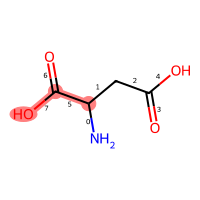

In [56]:
# Example

rid = '1162'
substrate_smiles = decarb[rid]['smarts'].split('>>')[0]
substrate_mol = Chem.MolFromSmiles(substrate_smiles)
rc = decarb[rid]['reaction_center'][0]
display(SVG(draw_molecule(substrate_smiles, hilite_atoms=rc, draw_options={'addBondIndices': True})))

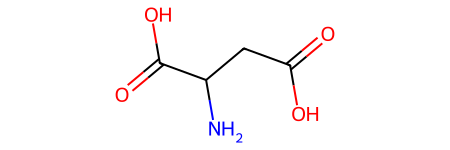

In [61]:
# Vary r

r = 3
display(rc_neighborhood(substrate_mol, radius=r, reaction_center=rc))

In [23]:
r_hop_submols = defaultdict(lambda : defaultdict(lambda : Chem.Mol())) # r-hop substructures
r_hop_cts = defaultdict(lambda : defaultdict(int)) # r-hop counts per substructure
for r in range(0, 10):
    for rid in decarb.keys():
        substrate_smiles = decarb[rid]['smarts'].split('>>')[0]
        substrate_mol = Chem.MolFromSmiles(substrate_smiles)
        rc = decarb[rid]['reaction_center'][0]
        submol = rc_neighborhood(substrate_mol, radius=r, reaction_center=rc)
        subsmiles = Chem.MolToSmiles(submol)
        r_hop_submols[r][subsmiles] = submol
        r_hop_cts[r][subsmiles] += 1

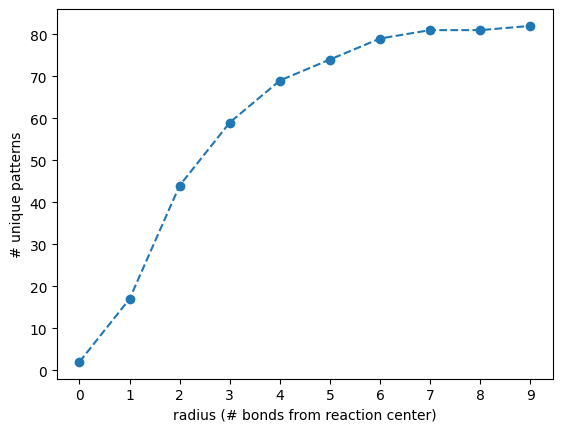

In [24]:
radii, n_unique_patts = zip(*[(k, len(v)) for k, v in r_hop_submols.items()])
fig, ax = plt.subplots()
ax.plot(radii, n_unique_patts, ls='--', marker='o')
ax.set_ylabel('# unique patterns')
ax.set_xlabel('radius (# bonds from reaction center)')
ax.set_xticks(radii)
plt.show()

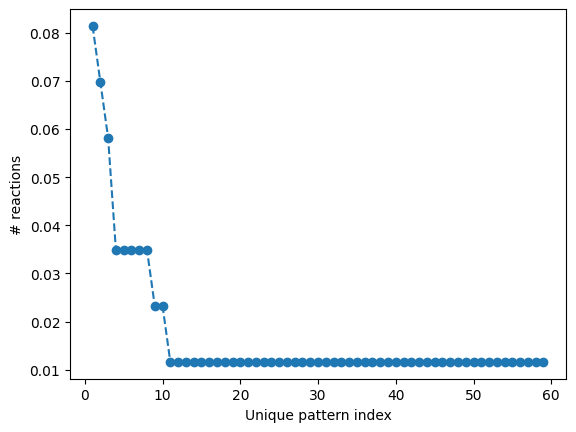

In [62]:
def substructure_pmf(r: int, r_hop_cts=r_hop_cts):
    r_srt_ct = sorted(r_hop_cts[r].values(), reverse=True)
    tot = sum(r_srt_ct)
    r_srt_ct = [elt / tot for elt in r_srt_ct]
    rank = [i for i in range(1, len(r_srt_ct) + 1)]
    fig, ax = plt.subplots()
    ax.plot(rank, r_srt_ct, ls='--', marker='o')
    ax.set_ylabel('# reactions')
    ax.set_xlabel('Unique pattern index')
    plt.show()

substructure_pmf(r=3)

CCCC(N)C(=O)O
# reactions: 7


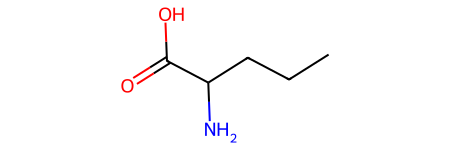

cc(c)CC(N)C(=O)O
# reactions: 6


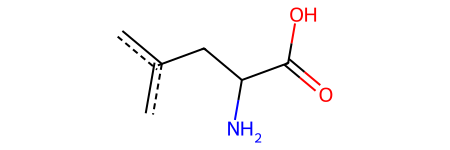

CCCCC(=O)O
# reactions: 5


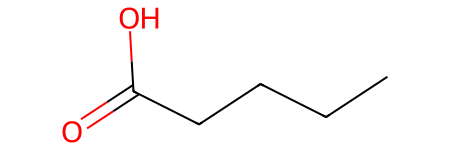

NC(COP)C(=O)O
# reactions: 3


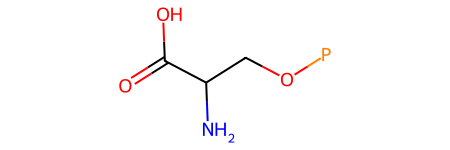

cc(c)CC(=O)C(=O)O
# reactions: 3


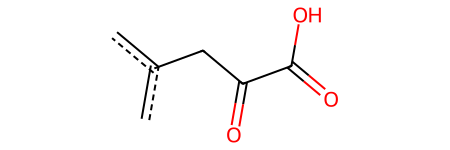

CCCC(=O)C(=O)O
# reactions: 3


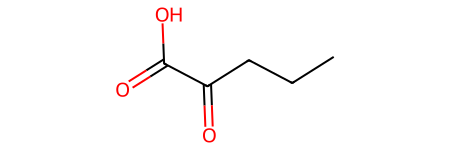

cc(c)C=CC(=O)O
# reactions: 3


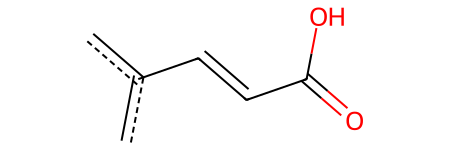

NCCC(N)C(=O)O
# reactions: 3


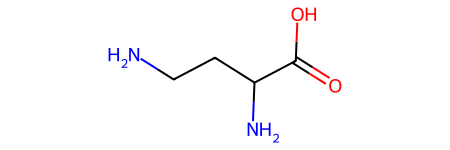

NC(CC(=O)O)C(=O)O
# reactions: 2


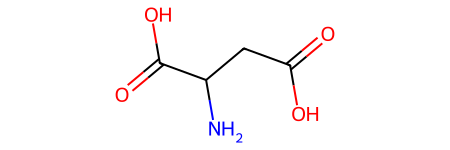

O=C(O)C(O)(CO)C(=O)CO
# reactions: 2


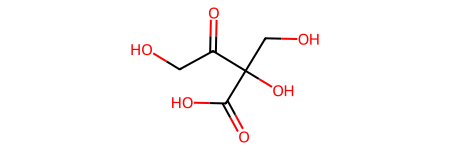

CCC(C(=O)O)C(=O)SC
# reactions: 1


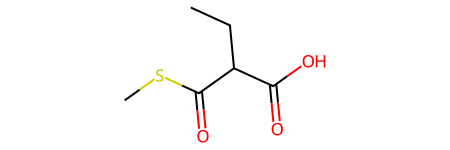

CC=CC(C(=O)O)=C(N)C(=O)O
# reactions: 1


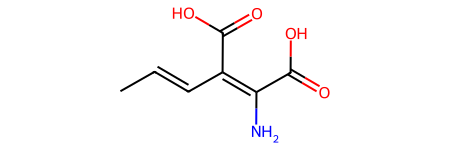

CC(O)n1c(C(=O)O)cc(=O)[nH]c1=O
# reactions: 1


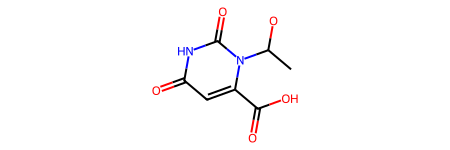

O=C(O)CC(=O)C(=O)O
# reactions: 1


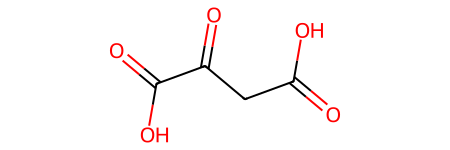

NC(CC[S+])C(=O)O
# reactions: 1


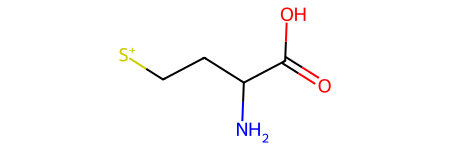

O=C(O)c1cccc(O)c1O
# reactions: 1


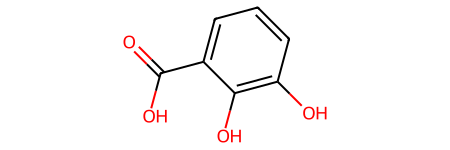

Cn1cnc(C(=O)O)c1N
# reactions: 1


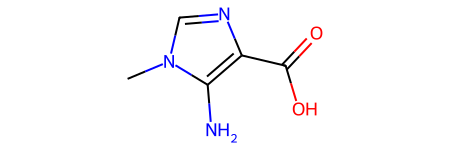

O=C(O)c1c(O)cccc1O
# reactions: 1


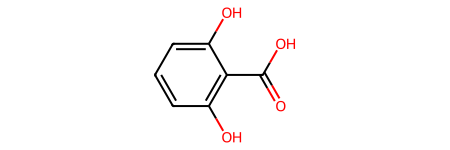

O=C(O)C(O)C(=O)CO
# reactions: 1


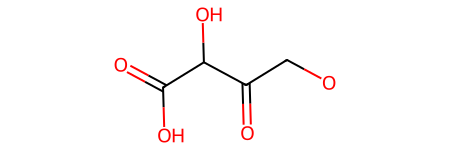

CSC(=O)CC(=O)O
# reactions: 1


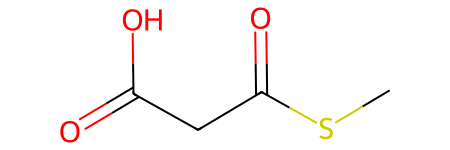

O=C(O)C1OC(O)CC(O)C1O
# reactions: 1


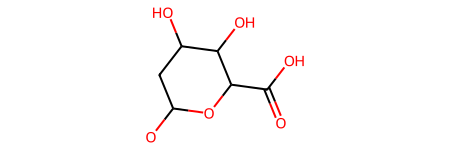

*C(=O)C(=O)O
# reactions: 1


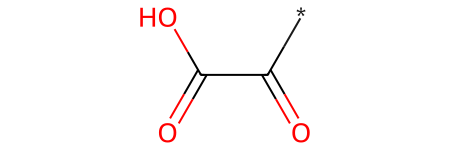

cc1cCC(C)(O)C(C(=O)O)C1=O
# reactions: 1


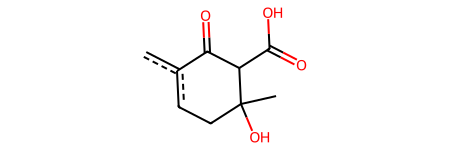

CC(=O)CC(=O)O
# reactions: 1


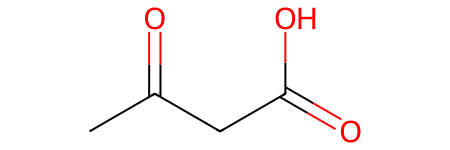

CC(OP)C(N)C(=O)O
# reactions: 1


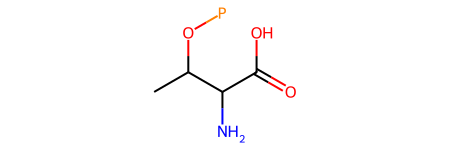

CSC(=O)C(C)C(=O)O
# reactions: 1


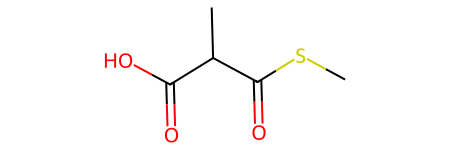

CC(=O)C(=O)O
# reactions: 1


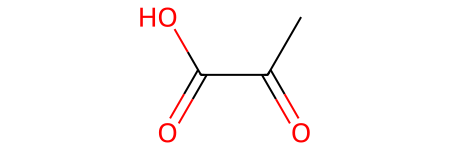

CC(=O)NC(CS)C(=O)O
# reactions: 1


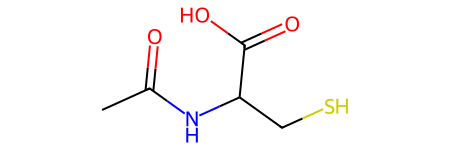

CC(=O)C(C)(O)C(=O)O
# reactions: 1


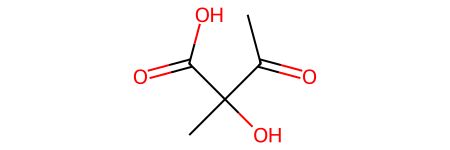

CCC(=CC(=O)O)C(=O)O
# reactions: 1


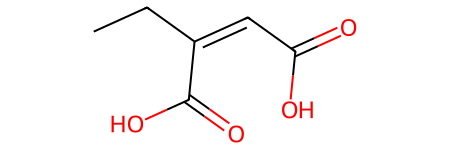

CC(C)CC(=O)C(=O)O
# reactions: 1


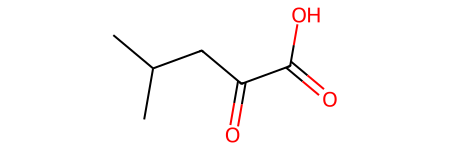

CC(O)C(=O)C(O)C(=O)O
# reactions: 1


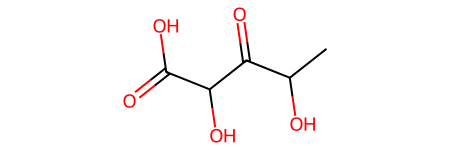

cc(n)CC(N)C(=O)O
# reactions: 1


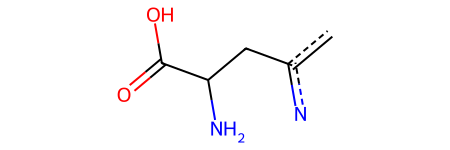

NC(CS(=O)O)C(=O)O
# reactions: 1


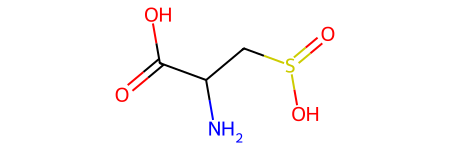

O=C(O)C(=O)CS(=O)(=O)O
# reactions: 1


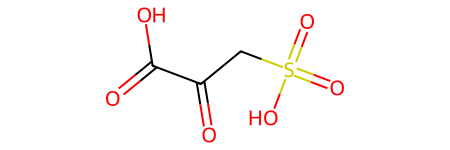

CC(C)C(=O)C(=O)O
# reactions: 1


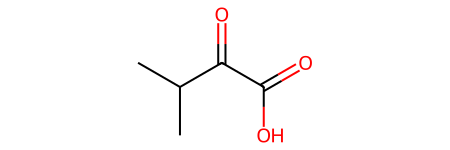

O=C(O)C(O)C(O)C(=O)O
# reactions: 1


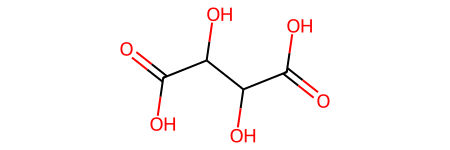

CCC(C)C(=O)C(=O)O
# reactions: 1


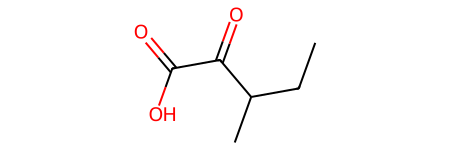

O=C(O)c1ccc(O)cc1C(=O)O
# reactions: 1


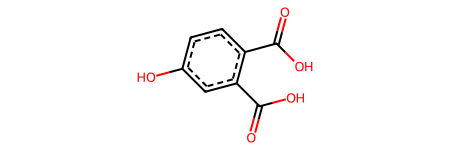

NC(CS(=O)(=O)O)C(=O)O
# reactions: 1


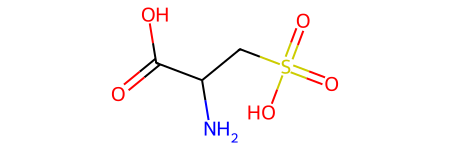

NC(CO)C(=O)O
# reactions: 1


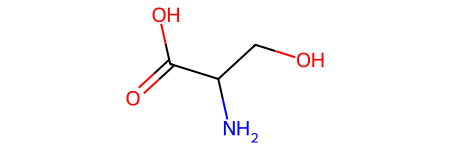

O=C(O)c1ccccc1O
# reactions: 1


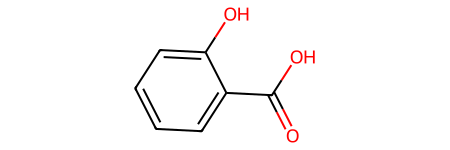

CCC(=O)C(=O)O
# reactions: 1


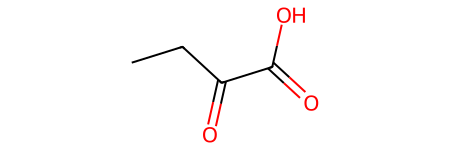

CCSC(=O)C(=O)O
# reactions: 1


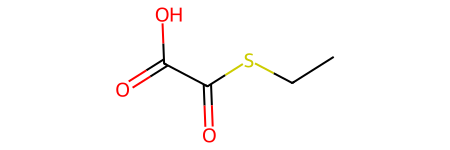

Cc1ncc(C(=O)O)c(C(=O)O)c1O
# reactions: 1


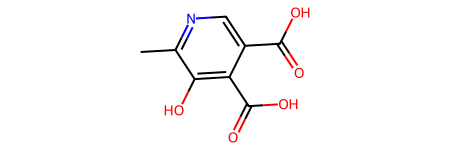

O=CCC(=O)O
# reactions: 1


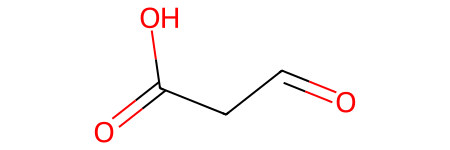

O=C(O)CC(O)C(=O)O
# reactions: 1


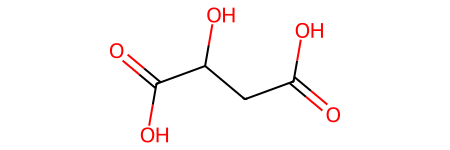

ccc(cc)C(=O)C(=O)O
# reactions: 1


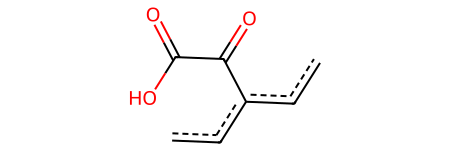

COCC(N)C(=O)O
# reactions: 1


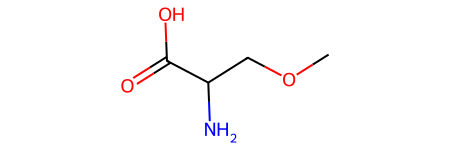

*C(C)(C(=O)O)C(=O)O
# reactions: 1


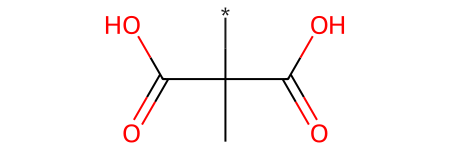

O=C(O)C(=O)O
# reactions: 1


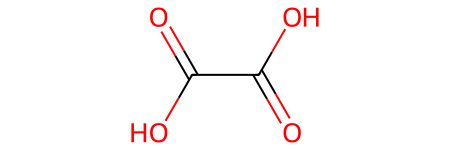

O=C(O)c1cccc(O)c1
# reactions: 1


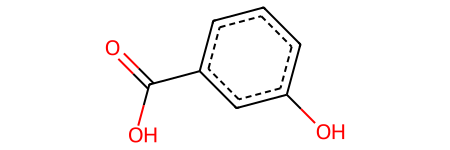

O=C(O)c1ccc[nH]1
# reactions: 1


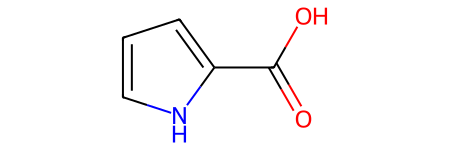

O=C(O)C(=O)CP(=O)(O)O
# reactions: 1


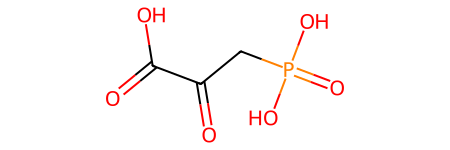

NC(CS)C(=O)O
# reactions: 1


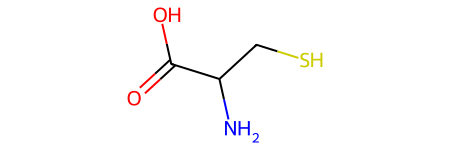

Cc1cccc(O)c1C(=O)O
# reactions: 1


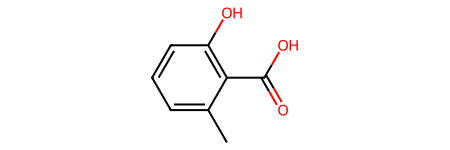

cc(c)c(c[nH])CC(=O)O
# reactions: 1


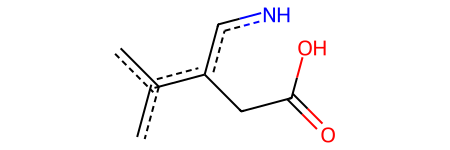

CNCC(N)C(=O)O
# reactions: 1


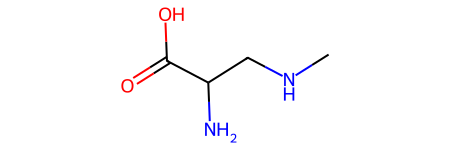

O=C(O)C(=O)CCS
# reactions: 1


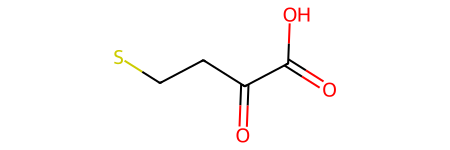

In [66]:
# Display substructures

r = 3
smi2mol = r_hop_submols[r]
srt_smi2ct = sorted(r_hop_cts[r].items(), key=lambda x : x[1], reverse=True)
for s, ct in srt_smi2ct:
    mol = smi2mol[s]
    print(s)
    print(f"# reactions: {ct}")
    display(mol)

In [33]:
srt_smi2ct

[('CC(N)C(=O)O', 30),
 ('CC(=O)C(=O)O', 14),
 ('CCC(=O)O', 11),
 ('cc(c)C(=O)O', 7),
 ('CC(O)C(=O)O', 4),
 ('C=CC(=O)O', 4),
 ('CC(C)C(=O)O', 3),
 ('CC(C)(O)C(=O)O', 3),
 ('cc(n)C(=O)O', 2),
 ('C=C(C)C(=O)O', 1),
 ('*C(=O)C(=O)O', 1),
 ('O=C(O)C(=O)S', 1),
 ('cC(=O)C(=O)O', 1),
 ('*C(C)(C)C(=O)O', 1),
 ('O=C(O)C(=O)O', 1),
 ('cc([nH])C(=O)O', 1),
 ('cCC(=O)O', 1)]

From case study

['A0A248QE08']


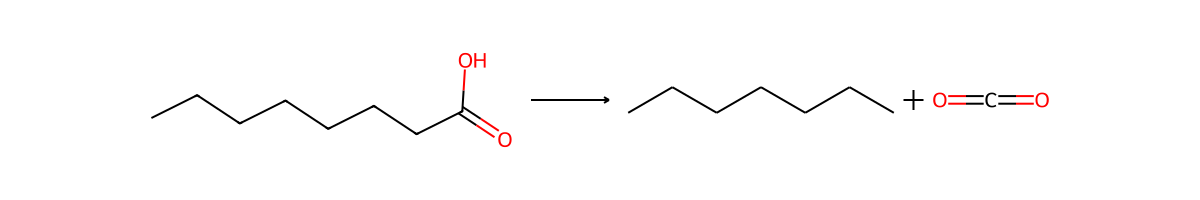

In [27]:
print([e['uniprot_id'] for e in krs['17305']['enzymes']])
SVG(draw_reaction(krs['17305']['smarts']))

['Q05115']


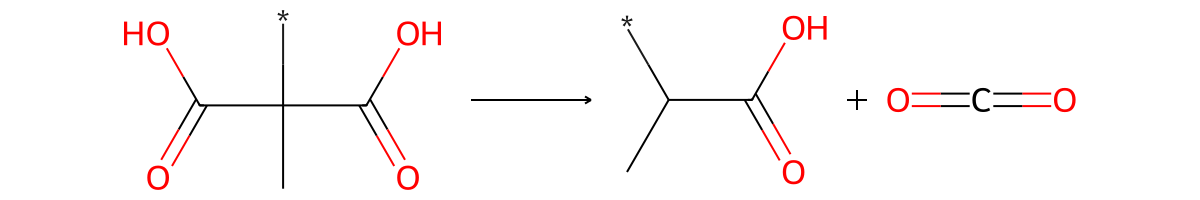

In [28]:
print([e['uniprot_id'] for e in krs['15876']['enzymes']])
SVG(draw_reaction(krs['15876']['smarts']))